<a href="https://colab.research.google.com/github/yukaberry/detect_ai_content/blob/development/notebooks/texts/lina_text_external_features_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import string

In [2]:
from google.colab import files
uploaded = files.upload()

Saving new_dataset.csv to new_dataset.csv


In [9]:
import time
import time
from functools import wraps

def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function '{func.__name__}' executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper


In [3]:
df = pd.read_csv('new_dataset.csv')
df.head()


,text,generated
0,"Furthermore, the additional hours spent in sch...",1.0
1,other student have their young ones at home wh...,0.0
2,Always set a goal for yourself.\n\nEveryone in...,0.0
3,"Additionally, online classes often provide add...",1.0
4,Cars have bin around for awhile and this have ...,0.0


In [4]:
df.shape

(4670, 2)

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess_text(text, remove_stopwords=True):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords, if specified
    if remove_stopwords:
        text = ' '.join(word for word in text.split() if word not in stop_words)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing to the text column
df['cleaned_text'] = df['text'].apply(lambda x: preprocess_text(x))

# Select only the necessary columns for modeling
cleaned_df = df[['cleaned_text', 'generated']]

# Display the cleaned dataset
print(cleaned_df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                        cleaned_text  generated
0  think classes highschool would longer students...        0.0
1  ces students would time work give time teacher...        0.0
2  noted good character beneficial individual als...        1.0
3  people laid back time find lagging behind miss...        1.0
4  recognizing great student work teachers provid...        1.0


# Functions  : SBERT, Cosine Similarity, LDA

In [16]:
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

@timer
def generate_sbert_embeddings_with_pca(df, text_column='cleaned_text', n_components=50):
    # Initialize SBERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Using SBERT for embeddings
    embeddings = df[text_column].apply(lambda x: model.encode(x)).tolist()

    # Convert embeddings to DataFrame
    embedding_df = pd.DataFrame(embeddings)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embedding_df)

    # Create DataFrame for reduced embeddings
    reduced_df = pd.DataFrame(reduced_embeddings, columns=[f'pca_embedding_{i}' for i in range(n_components)])
    return pd.concat([df.reset_index(drop=True), reduced_df], axis=1)

In [13]:
import torch
import numpy as np
from sklearn.cluster import MiniBatchKMeans

@timer
def calculate_cosine_similarity(df, embeddings_column_prefix='pca_embedding_', n_components=50):
    # Extract embedding columns
    embedding_columns = [f'{embeddings_column_prefix}{i}' for i in range(n_components)]

    # Ensure embeddings are in float32
    embeddings = df[embedding_columns].astype(np.float32).values

    # K-Means clustering to identify cluster centers for AI and human texts
    kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=100).fit(embeddings)
    df['cluster_label'] = kmeans.labels_
    cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

    similarities = []
    for _, row in df.iterrows():
        # Convert row embedding to tensor and enforce float32
        text_embedding = torch.tensor(row[embedding_columns].values.astype(np.float32), dtype=torch.float32)
        cluster_center = cluster_centers[row['cluster_label']]

        # Calculate cosine similarity
        similarity = torch.nn.functional.cosine_similarity(text_embedding.unsqueeze(0), cluster_center.unsqueeze(0)).item()
        similarities.append(similarity)

    df['cosine_similarity'] = similarities
    return df.drop(columns=['cluster_label'])



In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

@timer
def generate_topics(df, text_column='cleaned_text', n_topics=5):
    # Vectorize text data
    vectorizer = CountVectorizer(stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(df[text_column])

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_matrix = lda.fit_transform(doc_term_matrix)

    # Create DataFrame for topics
    topics_df = pd.DataFrame(lda_matrix, columns=[f'topic_{i}' for i in range(n_topics)])
    return pd.concat([df.reset_index(drop=True), topics_df], axis=1)

# Calling Functions

In [24]:
# SBERT embeddings with PCA

df_with_embeddings = generate_sbert_embeddings_with_pca(cleaned_df, text_column='cleaned_text')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Function 'generate_sbert_embeddings_with_pca' executed in 504.4416 seconds


In [25]:
df_with_embeddings.head()


,cleaned_text,generated,pca_embedding_0,pca_embedding_1,pca_embedding_2,pca_embedding_3,pca_embedding_4,pca_embedding_5,pca_embedding_6,pca_embedding_7,...,pca_embedding_40,pca_embedding_41,pca_embedding_42,pca_embedding_43,pca_embedding_44,pca_embedding_45,pca_embedding_46,pca_embedding_47,pca_embedding_48,pca_embedding_49
0,think classes highschool would longer students...,0.0,-0.373101,-0.036132,-0.187837,0.088147,-0.005403,-0.005987,0.109773,-0.046148,...,0.018773,-0.033711,0.006180,0.045485,-0.051407,-0.062605,0.068607,-0.003468,-0.030714,-0.024950
1,ces students would time work give time teacher...,0.0,-0.358365,0.032742,-0.070289,0.020354,0.093190,0.165870,0.031116,-0.087475,...,-0.085300,0.004333,0.041652,0.004491,-0.082866,0.047585,0.042538,-0.040613,-0.060150,0.005598
2,noted good character beneficial individual als...,1.0,0.300775,0.152412,0.065018,-0.152755,0.185089,-0.107908,-0.149314,0.048571,...,0.096647,-0.050265,0.036018,0.019091,0.088605,0.005996,-0.056946,0.051177,0.152416,0.112172
3,people laid back time find lagging behind miss...,1.0,0.157668,0.301349,0.136172,-0.177722,-0.083142,-0.014057,0.039815,-0.026422,...,0.051661,-0.035499,0.035049,-0.022817,-0.062086,0.094630,0.084555,0.005370,-0.058929,0.005754
4,recognizing great student work teachers provid...,1.0,-0.025147,0.352870,-0.070498,-0.004575,0.076243,-0.002786,-0.040430,-0.227878,...,0.013626,0.000713,-0.062011,0.095336,0.040967,0.064123,0.000610,-0.106173,-0.000477,0.008915


In [26]:
import torch
torch.cuda.empty_cache()

In [27]:
# Call the function with the updated dataframe

df_with_cosine_similarity = calculate_cosine_similarity(df_with_embeddings)


In [22]:
# Generate topics using LDA

df_with_lda = generate_topics(df_with_cosine_similarity)

In [ ]:
external_df = df_with_lda[[col for col in df_with_lda.columns if 'pca_embedding' in col] +
                       ['cosine_similarity'] +
                       [col for col in df_with_lda.columns if 'topic_' in col] +
                       ['generated']]


In [ ]:
external_df.head()

,pca_embedding_0,pca_embedding_1,pca_embedding_2,pca_embedding_3,pca_embedding_4,pca_embedding_5,pca_embedding_6,pca_embedding_7,pca_embedding_8,pca_embedding_9,...,pca_embedding_47,pca_embedding_48,pca_embedding_49,cosine_similarity,topic_0,topic_1,topic_2,topic_3,topic_4,generated
0,-0.557774,0.127374,0.111626,-0.071414,-0.182616,-0.048701,-0.183947,-0.155692,0.079918,0.104273,...,0.027248,-0.003275,-0.002291,0.014723,0.001800,0.001794,0.103281,0.854095,0.039029,1.0
1,-0.341954,-0.035213,-0.205996,-0.107912,0.209953,0.032938,0.243501,-0.004971,-0.048225,0.047593,...,-0.032310,0.045303,-0.053879,0.244158,0.323706,0.001047,0.001059,0.673149,0.001039,0.0
2,0.238240,0.157648,-0.379187,0.009410,-0.195888,0.000856,-0.028220,-0.001200,0.116871,0.053628,...,0.018484,-0.019929,-0.070686,0.226587,0.577923,0.263154,0.119316,0.001802,0.037805,0.0
3,-0.471218,0.100714,0.050300,-0.132655,0.062544,0.076803,0.180054,0.091998,-0.130060,0.174821,...,-0.011801,-0.022230,-0.002550,0.034549,0.001357,0.001342,0.001345,0.994618,0.001338,1.0
4,0.103979,-0.486591,0.089517,0.046074,-0.319420,0.120667,-0.131892,0.141457,-0.033489,-0.081295,...,0.054516,0.005976,0.045144,0.524944,0.000744,0.000734,0.000741,0.000729,0.997052,0.0


In [ ]:
external_df.to_csv('external_df.csv', index=False)

In [ ]:
files.download('external_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

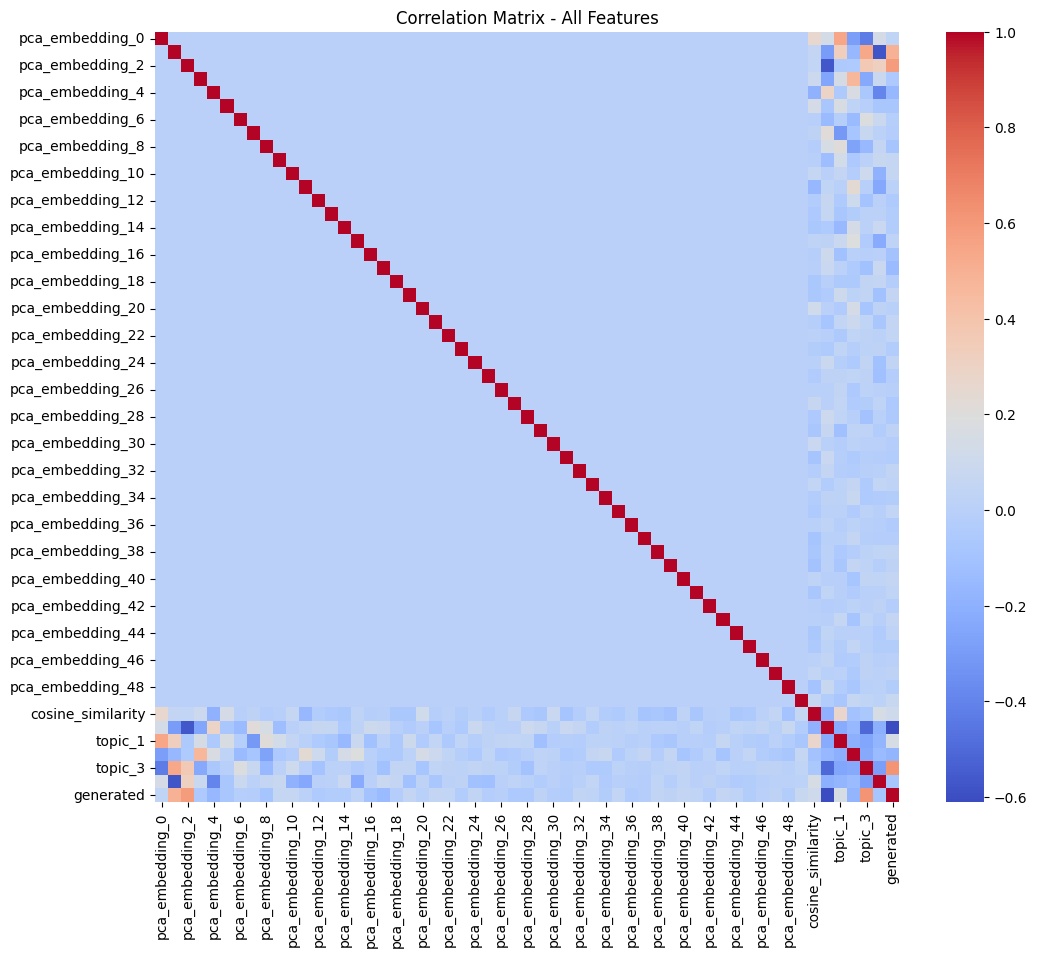


Correlation with 'generated' column:
 generated            1.000000
topic_3              0.616917
pca_embedding_2      0.588688
pca_embedding_1      0.493650
topic_1              0.155895
cosine_similarity    0.110582
pca_embedding_49     0.075397
pca_embedding_10     0.062601
pca_embedding_9      0.059921
pca_embedding_21     0.056065
pca_embedding_19     0.052087
pca_embedding_43     0.052000
pca_embedding_40     0.050652
pca_embedding_35     0.048917
pca_embedding_22     0.046090
pca_embedding_38     0.041466
pca_embedding_32     0.039016
pca_embedding_24     0.038432
pca_embedding_0      0.033740
pca_embedding_41     0.032732
pca_embedding_15     0.030271
pca_embedding_44     0.027965
pca_embedding_33     0.025518
pca_embedding_39     0.024239
pca_embedding_29     0.024038
pca_embedding_47     0.023321
pca_embedding_11     0.008847
pca_embedding_46     0.001884
pca_embedding_20    -0.000375
pca_embedding_26    -0.009935
pca_embedding_6     -0.012797
pca_embedding_18    -0.019573
p

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for all features
plt.figure(figsize=(12, 10))
sns.heatmap(external_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix - All Features")
plt.show()

correlation_with_generated = external_df.corr()['generated'].sort_values(ascending=False)
print("\nCorrelation with 'generated' column:\n", correlation_with_generated)

# Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np

# Define X and y
X = external_df.drop(columns=['generated'])
y = external_df['generated']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define metrics function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) if hasattr(model, "predict_proba") else np.nan
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'AUC': auc}

# Define the models for evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Initialize dictionary to store trained models
trained_models = {}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[model_name] = model  # Store the trained model
    results[model_name] = evaluate_model(model, X_test, y_test)

# Display results in DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training Logistic Regression...
Training SVM...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Number of positive: 1857, number of negative: 1879
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497056 -> initscore=-0.011777
[LightGBM] [Info] Start training from score -0.011777
Training K-Nearest Neighbors...
Training Naive Bayes...
Training Gradient Boosting...
Training AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression  0.947537   0.961276  0.929515  0.945129  0.986871
SVM                  0.963597   0.981651  0.942731  0.961798       NaN
Random Forest        0.961456   0.981567  0.938326  0.959459  0.989001
XGBoost              0.959315   0.974886  0.940529  0.957399  0.992415
LightGBM             0.964668   0.986143  0.940529  0.962796  0.993227
K-Nearest Neighbors  0.957173   0.972603  0.938326  0.955157  0.986816
Naive Bayes          0.880086   0.899533  0.848018  0.873016  0.943580
Gradient Boosting    0.953961   0.976798  0.927313  0.951412  0.986894
AdaBoost             0.930407   0.933185  0.922907  0.928018  0.980690


In [28]:
import pickle

# Assuming 'model_xgb', 'model_gb', and 'model_svm' are your trained models
# Serialize and save the models using pickle

# For XGBoost
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)

# For Gradient Boosting
with open('gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(model_gb, file)

# For SVM
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(model_svm, file)

NameError: name 'model_xgb' is not defined